# PBMC10K Multiome

In [1]:
import numpy as np
import polars as pl
import snapatac2 as snap  
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy.io
import os
import anndata as ad # Anndata version must > 0.8
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

import scATAnno
from scATAnno.SnapATAC2_spectral import *
from scATAnno.SnapATAC2_tools import *
from scATAnno.SnapATAC2_utils import *
from scATAnno import scATAnno_preprocess
from scATAnno import scATAnno_assignment
from scATAnno import scATAnno_integration
from scATAnno import scATAnno_plotting

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

default_28 = scATAnno_plotting.get_palettes("default28")
default_102 = scATAnno_plotting.get_palettes("default102")

In this tutorial, we apply PBMC reference atlas to PBMC 10K Multiome dataset. The input files are 1) reference atlas in h5ad format; 2) query data in mtx and tsv formats, whose features are aligned with PBMC reference peak. 

Download reference data

In [2]:
# !wget -O PBMC_reference_atlas_final.h5ad "https://www.dropbox.com/s/y9wc6h5mmydj7gf/PBMC_reference_atlas_final.h5ad?dl=1"

Download query data, including 1) scATAC (matrix.mtx, features.tsv and barcodes.tsv), features are the reference peak of PBMC reference atlas 2) scRNA (filtered_feature_bc_matrix.h5)

In [3]:
# !wget -O PBMC10k_multiome_vPBMCatlas.zip "https://www.dropbox.com/s/3g63m832mbeec4s/PBMC10k_multiome_vPBMCatlas.zip?dl=1"

Donwload palette file

In [4]:
# !wget -O reference_palette.pickle "https://www.dropbox.com/scl/fi/h9gryg9gwdegs8jaob8ga/reference_palette.pickle?rlkey=41zarytshwcowko0r7ndxkiih&st=bxgkyno9&dl=0"

We load reference atlas data and query data. Reference atlas is stored as h5ad AnnData in the data directory; query data is imported from QuickATAC output.

In [5]:
os.chdir("scATAnno-main")

output_name = "PBMC_10K_Multiome"
out_dir = os.path.join("scATAnno-main/case_study", output_name) 
os.makedirs(out_dir, exist_ok=True)

reference_data_path = "PBMC_reference_atlas_final.h5ad"
reference_data = scATAnno_preprocess.load_reference_data(reference_data_path)
query_data = scATAnno_preprocess.import_query_data(path = 'PBMC10k_multiome_vPBMCatlas/scATAC/',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv.gz',
                                    features_file = 'features.tsv.gz', 
                                    variable_prefix = "pbmc10k_query", 
                                    celltype_col = "celltypes",
                                    add_metrics=False)

Before performing integration, we check feature dimensions of the reference and query.

In [6]:
print(reference_data)
print(query_data)
assert reference_data.var.shape[0] == query_data.var.shape[0]

AnnData object with n_obs × n_vars = 39441 × 196618
    obs: 'celltypes', 'tissue', 'dataset'
View of AnnData object with n_obs × n_vars = 11909 × 196618
    obs: 'celltypes', 'tissue', 'dataset'


We integrate the reference atlas and query data using SnapATAC2 by 1) concatenating two datasets and selecting highly informative "landmark" reference cells to compute similarity matrix, normalize the matrix and eigen decompositionand and 2) performing Nystrom extension to project the remaining reference and query cells onto the same spectral embedding space

In [7]:
# Integrate reference and query data
integrated_adata = scATAnno_assignment.scATAnno_integrate(reference_data, query_data, variable_prefix = "pbmc10k_query", sample_size = 25000)

/Users/francis/Desktop/scATAnno-main/scATAnno/SnapATAC2_spectral.py:162: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["selected"] = selected_features


Compute similarity matrix
Normalization
Perform decomposition
Perform Nystrom extension


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [13:07<00:00, 262.61s/it]


The following method provides an alternative way to obtain "integrated_adata" (the box above). This method uses all reference samples. The time to calculate "integrated_adata" drops significantly (as only the "Perform Nystrom extension" step is performed) while the accuracy only have a minimal decrease.

In [8]:
# First we need to specify the paths for features and model. These two files were created in scATAnno-main/prep_data/scATAnno-reference-building-example:
#feature_file = "scATAnno-main/model_features.csv"
#model_file ="scATAnno-main/models_name.model"


# With both feature_file and model_file for our reference, we can project the data from query_data to the reference data in the spectral space:
#integrated_adata = scATAnno_assignment.scATAnno_query_projection(reference_data, query_data, feature_file, model_file)


Next, apply harmony to spectral embeddings of integrated data to regress out batch effects indicated in batch_col.

In [9]:
# Apply harmony to remove batch effects
integrated_adata_harmony = scATAnno_assignment.scATAnno_harmony(integrated_adata, batch_col = "dataset")

2025-01-07 14:08:49,680 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-07 14:08:49 - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-07 14:08:55,510 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-07 14:08:55 - INFO - sklearn.KMeans initialization complete.
2025-01-07 14:08:55,646 - harmonypy - INFO - Iteration 1 of 20
2025-01-07 14:08:55 - INFO - Iteration 1 of 20
2025-01-07 14:09:03,728 - harmonypy - INFO - Iteration 2 of 20
2025-01-07 14:09:03 - INFO - Iteration 2 of 20
2025-01-07 14:09:11,969 - harmonypy - INFO - Iteration 3 of 20
2025-01-07 14:09:11 - INFO - Iteration 3 of 20
2025-01-07 14:09:20,351 - harmonypy - INFO - Iteration 4 of 20
2025-01-07 14:09:20 - INFO - Iteration 4 of 20
2025-01-07 14:09:28,430 - harmonypy - INFO - Iteration 5 of 20
2025-01-07 14:09:28 - INFO - Iteration 5 of 20
2025-01-07 14:09:36,594 - harmonypy - INFO - Converged after 5 iterations
2025-01-07 14:09:36 - INFO - Converged after 5

In [10]:
integrated_adata_harmony

AnnData object with n_obs × n_vars = 51350 × 196618
    obs: 'celltypes', 'tissue', 'dataset'
    obsm: 'X_spectral', 'X_spectral_harmony'

we then plot UMAP of the integrated data using harmonized spectral embeddings. Optionally, we can save the AnnData object in an output directory.

In [11]:
# Plot UMAP using spectral embeddings
integrated_adata = scATAnno_assignment.scATAnno_umap(integrated_adata_harmony, out_dir, use_rep = "X_spectral_harmony", save = True)
integrated_adata

/opt/anaconda3/envs/scATAnno/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/scATAnno/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
... storing 'celltypes' as categorical
... storing 'tissue' as categorical


AnnData object with n_obs × n_vars = 51350 × 196618
    obs: 'celltypes', 'tissue', 'dataset'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'

... storing 'celltypes' as categorical
... storing 'tissue' as categorical


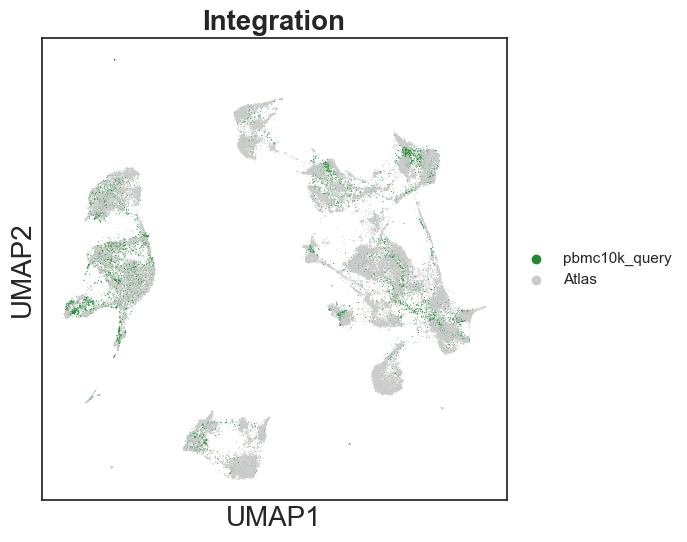

In [12]:
scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(integrated_adata, color="dataset", palette = ['#228833', '#cccccc'], show=True, title = "Integration")

We investigated cell types in the PBMC reference atlas and re-annotated gamma delta T cell cluster as MAIT cell cluster by showing chromatin accessibility of gene signatures in this cluster. 

After integration, we want to assign cell types to the query data by taking three steps. First, query cells are assigned labels using K-Nearest neighbors along with KNN-based uncertainty score. Second, query cell labels are corrected using weighted-distance-based uncertainty score. Third, query cells are clustered and annotated at the cluster level.

In [ ]:
uncertainty_threshold = 0.2
distance_threshold = 90
reference_label_col = "celltypes"
use_rep = "X_spectral_harmony"
atlas = "PBMC"

integrated_adata = sc.read_h5ad(os.path.join(out_dir, "1.Merged_query_reference.h5ad"))
integrated_adata = scATAnno_preprocess.add_variable(os.path.join(out_dir, "X_spectral_harmony.csv"), integrated_adata)
reference = integrated_adata[integrated_adata.obs['dataset'] == "Atlas", :].copy()
query = integrated_adata[integrated_adata.obs['dataset'] != "Atlas",:].copy()
# Perform KNN assignment
query_KNN = scATAnno_assignment.scATAnno_KNN_assign(reference, query, reference_label_col=reference_label_col, low_dim_col=use_rep)

In [ ]:
import pickle
#with open(os.path.join(out_dir, 'reference_palette.pickle'), 'rb') as handle:
with open(('reference_palette.pickle'), 'rb') as handle:
    celltype_palette = pickle.load(handle)

scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(reference, color="celltypes", palette = celltype_palette, title = "PBMC Reference Atlas")

In [ ]:
# Perform weighted-distance based assignment
query_distance = scATAnno_assignment.scATAnno_distance_assign(reference, query_KNN, reference_label_col=reference_label_col, distance_threshold=distance_threshold, atlas=atlas, uncertainty_threshold=uncertainty_threshold, use_rep = use_rep)

In [ ]:
# Perform cluster-level assignment
query_annotated = scATAnno_assignment.scATAnno_cluster_assign(query_distance, cluster_col = None, use_rep=use_rep)
query_annotated

In [ ]:
sc.pl.umap(query_annotated, color = "cluster_annotation",palette=celltype_palette, title = "scATAnno Annotation")

We benchmark scATAnno results with seurat annotation. Seurat annotation is stored in "Seurat_RNA_annotation.csv"

In [ ]:
seurat_df = pd.read_csv(os.path.join("PBMC10k_multiome_vPBMCatlas/","Seurat_RNA_annotation.csv"), index_col=0)
query_annotated = query_annotated[query_annotated.obs.index.isin(seurat_df.index)]
query_annotated.obs = pd.merge(query_annotated.obs, seurat_df, left_index=True, right_index=True)
query_annotated

In [ ]:
sc.pl.umap(query_annotated, color = "seurat_new_annotation", title = "Seurat Annotation", palette = default_28)

Lastly, we compare the annotation results between scATAnno and Seurat.

In [ ]:
outcomes2 = []
for i in query_annotated.obs["cluster_annotation"].index:
    if query_annotated.obs.loc[i,"cluster_annotation"] == query_annotated.obs.loc[i,"seurat_new_annotation"]:
        outcomes2.append("Consistent")
    elif query_annotated.obs.loc[i,"cluster_annotation"] == "unknown":
        outcomes2.append("Unknown")
    else: outcomes2.append("Inconsistent")
query_annotated.obs["outcomes2"] = outcomes2
sc.pl.umap(query_annotated, color = "outcomes2", palette= ['#1f77b4','#ff7f0e','#279e68'], title = "Comparison")

In [ ]:
outcomes = []
for i in query_annotated.obs["cluster_annotation"].index:
    if query_annotated.obs.loc[i,"cluster_annotation"] == query_annotated.obs.loc[i,"seurat_new_annotation"]:
        outcomes.append("Consistent")
    else: outcomes.append("Inconsistent")
query_annotated.obs["outcomes"] = outcomes

adata_query = query_annotated.copy()
variable_col = "cluster_annotation"
outcome_col = "outcomes"
listdict = []
for ct in adata_query.obs[variable_col].unique():
    # print(len(adata_query.obs[adata_query.obs['tissue'] == ct]))
    tmp_dict = {}
    for pt in np.unique(adata_query.obs[outcome_col]):
        tmp_dict[pt] = (
            np.sum(
                adata_query.obs[adata_query.obs[variable_col] == ct][outcome_col] == pt
            )
            # / len(adata_query.obs[adata_query.obs[variable_col] == ct])
        )
    l = len(adata_query.obs[adata_query.obs[variable_col] == ct])
    tmp_dict['ct'] = f'{ct} ({l})'
    tmp_dict['n_cells'] = len(adata_query.obs[adata_query.obs[variable_col] == ct])
    listdict.append(tmp_dict)


df = pd.DataFrame(listdict).set_index('ct').sort_values(by='ct')
df = df.iloc[0:df.shape[0]-1].sort_values("n_cells", ascending=True)
print(df)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2, 6))
df[df.columns[0:len(df.columns)-1]].plot(kind='barh', stacked=True, ax=ax, width=1.0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_xlabel('Cell Numbers')
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.grid(False)
sns.despine()
plt.show()

In [ ]:
query_annotated.obs

In [ ]:
query_annotated.write(os.path.join(out_dir, "query_annotated.h5ad"))

To examine B cell subtypes, we leverage scRNA-profile to show signature genes

In [ ]:
# Read in scRNA profile
RNA_anndata = sc.read_10x_h5("PBMC10k_multiome_vPBMCatlas/scRNA/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5")
RNA_anndata.obs.index = [ i+ "_pbmc10k_query" for i in RNA_anndata.obs.index]
RNA_anndata = RNA_anndata[RNA_anndata.obs.index.isin(query_annotated.obs.index)]

In [ ]:
RNA_anndata

In [ ]:
RNA_anndata.obs = pd.merge(RNA_anndata.obs, query_annotated.obs[["cluster_annotation", "seurat_new_annotation"]], left_index=True, right_index=True)
UMAP_df = pd.DataFrame(query_annotated.obsm["X_umap"])
UMAP_df.index = query_annotated.obs.index
UMAP_df.columns = ["UMAP_1", "UMAP_2"]
UMAP_df = UMAP_df.loc[RNA_anndata.obs.index]
RNA_anndata.obsm["X_umap"] = np.array(UMAP_df)
new_categories = np.unique(query_annotated.obs["cluster_annotation"])
RNA_anndata.obs["cluster_annotation"] = RNA_anndata.obs["cluster_annotation"].cat.set_categories(new_categories)

In [ ]:
RNA_anndata.obs

In [ ]:
sc.pp.filter_genes(RNA_anndata, min_cells=3)
sc.pp.normalize_total(RNA_anndata, target_sum=1e4)
sc.pp.log1p(RNA_anndata)
sc.pp.highly_variable_genes(RNA_anndata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(RNA_anndata, max_value=10)
RNA_anndata.var_names_make_unique()

In [ ]:
N_col = 2
N_row = 2

markergenes = ["CD27","TNFRSF13B", # memoryB
              "IGHM", "TCL1A", # naive B
              ]
fig, axes=plt.subplots(nrows= N_row , ncols= N_col , figsize=(N_col*2,N_row*2), 
                       sharex=True,sharey=True, )
for i in range(len(markergenes) ):
    i_row = int(i/N_col)
    i_col = i%N_col
    ax = axes[i_row, i_col]
    sc.pl.umap(RNA_anndata, color= markergenes[i], 
                    title =  markergenes[i],
               # title = "", 
               show=False, ax = ax, legend_loc=None,color_map='plasma', colorbar_loc = None, )
    ax.set_xlabel('')
    ax.set_ylabel('')
fig.tight_layout()
plt.show()

snap.tl.marker_regions function from snapATAC2 aggregates signal across cells and utilizes z-scores to identify specifically enriched peaks. 
(https://kzhang.org/SnapATAC2/tutorials/diff.html)

In [ ]:
marker_peaks = snap.tl.marker_regions(reference_data, groupby='celltypes', pvalue=0.01)

Plot cell type specific peaks

In [ ]:
snap.pl.regions(reference_data, groupby='celltypes', peaks=marker_peaks, interactive=False)

The following outputs cell type specific peaks into separate documents. 

In [ ]:
for i in range(len(marker_peaks)):
    key = list(marker_peaks.keys())[i]
    data = marker_peaks[key]
    df = pd.DataFrame(data, columns=['peak'])
    df.to_csv(f'{key}_peak.csv', index=False)